In [1]:
#important imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import sys
import librosa
import librosa.display
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import wave
from scipy.io.wavfile import read
from scipy.io import wavfile

import glob
import os.path
from pathlib import Path
import glob
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential, Model, model_from_json, load_model
from keras.layers import Dense, Embedding, LSTM, Reshape, Bidirectional
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D,GlobalAveragePooling3D, BatchNormalization, Flatten, Dropout,GlobalAveragePooling1D,
                          GlobalMaxPool2D, GlobalMaxPool3D, MaxPool2D, concatenate, Activation, Input, Dense, TimeDistributed)
from tensorflow.keras.utils import to_categorical, custom_object_scope
import json
from matplotlib.pyplot import specgram



In [2]:
#mounting my drive, because my data and saved models are in my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
a1=[]

In [5]:
#importing my spontaneous speech test data and then extracting mffcs
for file in glob.glob("/content/drive/MyDrive/DATA/11/test/*.wav"):

        y1, sr1 = librosa.load(file, sr = None, mono=True)
        segment = y1[:int(85 * sr1)]
        mfccs1= librosa.feature.mfcc(y=segment, sr=sr1,n_mfcc=13)
        filename1 = Path(file).stem
        x1 = filename1.split("_")
        a1.append([x1[0],mfccs1])

In [6]:
s1=[]

In [8]:
#importing phone posterior probs for spontaneous speech test data from my saved data
file_path1='/content/drive/MyDrive/DATA/test_probs_eng.json'
with open(file_path1,'r')as json_file:
  s1=json.load(json_file)

In [9]:
#reading this saved file for having the id and label of each data
import pandas as pd
df1 = pd.read_csv('/content/drive/MyDrive/DATA/test_mfcc_02.csv')

In [10]:
c=[]
d=[]

In [15]:
for i in range(141):
        c.append([a1[i][0], ((a1[i][1]).T)[0:6551]])
for i in range(141):
        d.append([s1[i][0], ((s1[i][1]))[0:3493]])

In [16]:
c[0]

['JPF',
 array([[-631.6022   ,   92.55098  ,   14.563326 , ...,    3.8776007,
            6.675474 ,    5.2513165],
        [-599.9427   ,  103.32507  ,   11.901133 , ...,    9.029417 ,
            6.2487717,    3.0229204],
        [-600.01556  ,  106.93611  ,   13.113664 , ...,    9.7090225,
           11.169284 ,    7.1019554],
        ...,
        [-609.3694   ,  125.819405 ,   26.239798 , ...,    1.8901277,
            2.4593773,    6.895993 ],
        [-612.9608   ,  123.530464 ,   27.4272   , ...,    0.7958834,
            7.5903673,    6.554936 ],
        [-621.6305   ,  121.581894 ,   30.091637 , ...,    4.3885384,
            8.417276 ,    7.629831 ]], dtype=float32)]

In [17]:
data_test_1=[]
data_test_2=[]

In [18]:
for i in range(141):
    for j in range(141):
        if c[i][0] == df1.iloc[j,0]:
            data_test_1.append([c[i][0], c[i][1], df1.iloc[j,14]])

for i in range(141):
    for j in range(141):
        if d[i][0] == df1.iloc[j,0]:
            data_test_2.append([d[i][0], d[i][1], df1.iloc[j,14]])

In [19]:
data_test_1.sort(key = lambda x: x[0])
data_test_2.sort(key = lambda x: x[0])

In [20]:
s1.sort(key = lambda x: x[0])

In [26]:
z = [0,0,0,0,0,0,0,0,0,0,0,0,0]
Z = np.array(z)
for i in range (13):
  Z[i]=np.float64(Z[i])

In [23]:
z = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
Z = np.array(z)
for i in range (32):
  Z[i]=np.float64(Z[i])

In [24]:
#padding the phone posterior probs data
for i in range(140):
  for j in range(3493-len(data_test_2[i][1])):
     data_test_2[i][1] = np.append(data_test_2[i][1], [Z], axis=0)

In [28]:
len(data_test_1[139][1])

6551

In [27]:
#padding the mfcc data
for i in range(140):
  for j in range(6551-len(data_test_1[i][1])):
     data_test_1[i][1] = np.append(data_test_1[i][1], [Z], axis=0)

In [29]:
x_test_1=[]
x_test_2=[]

In [30]:
for i in range(140):
    x_test_1.append(data_test_1[i][1])
for i in range(140):
    x_test_2.append(data_test_2[i][1])

In [31]:
x_test_1 = np.array(x_test_1)
x_test_2 = np.array(x_test_2)

In [32]:
len(x_test_2)

140

In [33]:
#this part is for normalizing just phone probs
epsilon = 1e-8  # A small value to avoid zero values

# Replace zero values with the epsilon value
x_test_2[x_test_2 == 0] = epsilon

# Calculate the logarithm of each value
X_test_2 = np.log(x_test_2)

In [35]:
#we can normalize both type of data here
import numpy as np

def z_score_normalize(data, mean=None, std=None):
    if mean is None:
        mean = np.mean(data, axis=(0, 1))
    if std is None:
        std = np.std(data, axis=(0, 1))
    normalized_data = (data - mean) / std
    return normalized_data, mean, std

X_test_1, mean, std = z_score_normalize(x_test_1)



In [36]:
for i in range(140):
  data_test_1[i][1] = X_test_1[i]

In [37]:
for i in range(140):
  data_test_2[i][1] = X_test_2[i]

In [44]:
#loading my best saved model for mfcc data, we can load saved models for phone probs here, too.
from keras.models import load_model
filepath='/content/drive/MyDrive/saved models/NEW_CNN_pos_SPON_3.hdf5'

model = load_model(filepath)

In [39]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_95 (Conv2D)          (None, 6551, 13, 16)      160       
                                                                 
 max_pooling2d_94 (MaxPooli  (None, 3275, 6, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_96 (Conv2D)          (None, 3275, 6, 32)       4640      
                                                                 
 max_pooling2d_95 (MaxPooli  (None, 1637, 3, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_97 (Conv2D)          (None, 1637, 3, 64)       18496     
                                                                 
 max_pooling2d_96 (MaxPooli  (None, 818, 1, 64)      

In [40]:
y_test = []

In [41]:
#getting labels
for i in range(140):
    y_test.append(data_test_1[i][2])

In [42]:
Y_test=np.array(y_test)

In [58]:
#getting test accuracy from the model trained on mfccs
test_loss, test_acc = model.evaluate(X_test_1, Y_test, verbose=0)
print("test Accuracy: ",test_acc)

test Accuracy:  0.8571428656578064


In [46]:
# Make predictions
predictions = model.predict(X_test_1)

5/5 [==============================] - 6s 1s/step


In [ ]:
p = np.sort(predictions, axis=0)

In [ ]:
def find_second_maximum(arr):
    if len(arr) < 2:
        return None  # If the array has less than 2 elements, return None

    first_max = float('-inf')
    second_max = float('-inf')

    for num in arr:
        if num > first_max:
            second_max = first_max
            first_max = num
        elif first_max > num > second_max:
            second_max = num

    return second_max if second_max != float('-inf') else None


second_max = find_second_maximum(predictions)
print("The second maximum value is:", second_max)

The second maximum value is: [0.97464865]


In [ ]:
def find_second_minimum(arr):
    if len(arr) < 2:
        return None  # If the array has less than 2 elements, return None

    first_min = float('inf')
    second_min = float('inf')

    for num in arr:
        if num < first_min:
            second_min = first_min
            first_min = num
        elif first_min < num < second_min:
            second_min = num

    return second_min if second_min != float('inf') else None



second_min = find_second_minimum(predictions)
print("The second minimum value is:", second_min)


The second minimum value is: [0.24231362]


In [47]:

np.max(predictions)

0.9999591

In [48]:

np.min(predictions)

1.4939117e-22

In [49]:
#getting the data that has the most confidence in calassification for negative(healthy)class
max_indice = np.where(predictions == 0.9999591)[0]

In [50]:
#getting the data that has the most confidence in calassification for positive(unhealthy)class
min_indice = np.where(predictions == 1.4939117e-22 )[0]

In [51]:
max_indice

array([11])

In [52]:
min_indice

array([48])

In [53]:
data_test_1[11][0]

'LAS'

In [54]:
data_test_1[48][0]

'MNY'

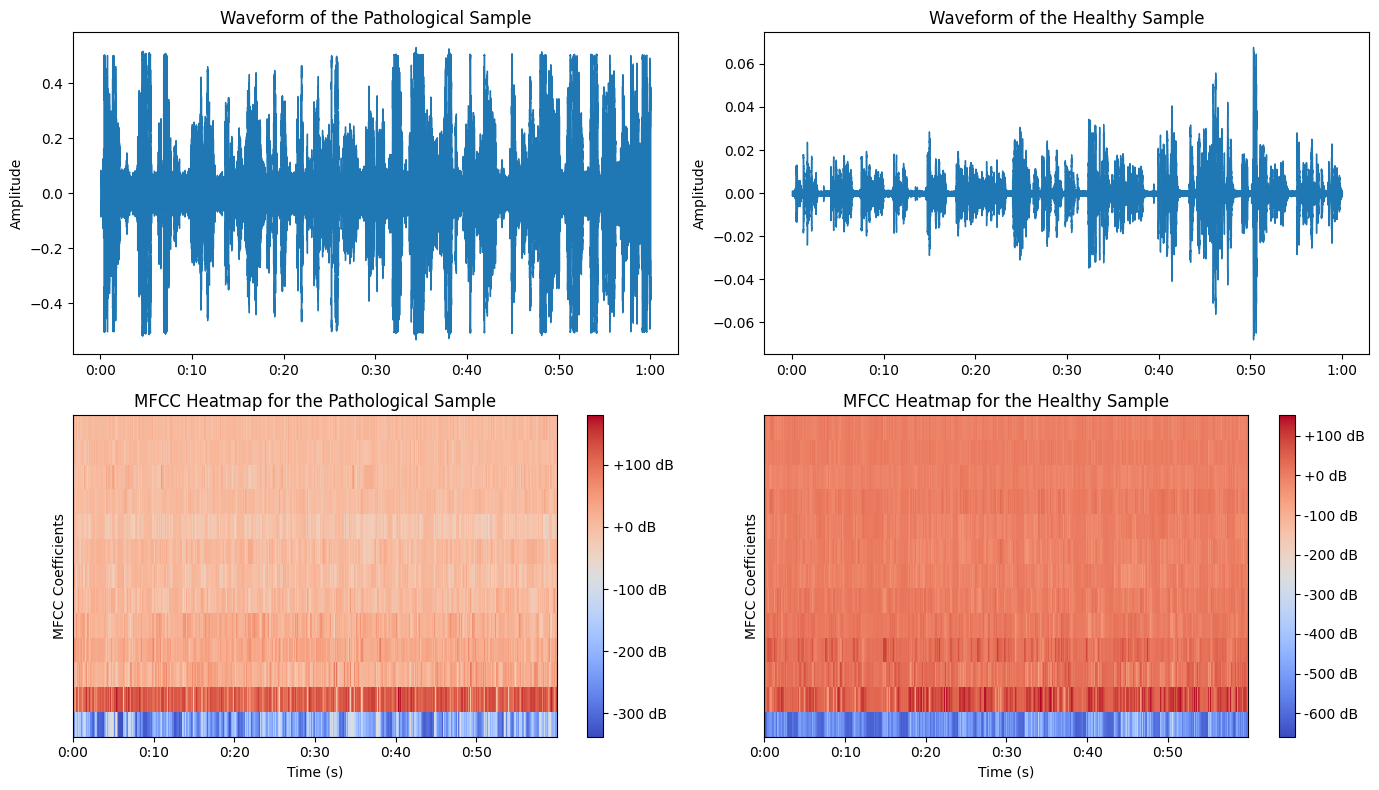

In [57]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Function to plot waveform and MFCC
def plot_waveform_and_mfcc(y, sr, ax_waveform, ax_mfcc, title):
    # Plot waveform
    librosa.display.waveshow(y, sr=sr, ax=ax_waveform)
    ax_waveform.set_title(f'Waveform of{title}')
    ax_waveform.set_xlabel('')
    ax_waveform.set_ylabel('Amplitude')

    # Extract and plot MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    img = librosa.display.specshow(mfccs, sr=sr, x_axis='time', ax=ax_mfcc)
    ax_mfcc.set_title(f'MFCC Heatmap for{title}')
    ax_mfcc.set_xlabel('Time (s)')
    ax_mfcc.set_ylabel('MFCC Coefficients')
    return img

# Load first audio file
filename1 = '/content/drive/MyDrive/DATA/11/test/LAS_11_M_P.wav'  # replace with your first wave file path
y1, sr1 = librosa.load(filename1, duration=60)

# Load second audio file
filename2 = '/content/drive/MyDrive/DATA/11/test/MNY_11_F_N.wav'  # replace with your second wave file path
y2, sr2 = librosa.load(filename2, duration=60)

# Create figure and axes
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Plot first audio file
img1 = plot_waveform_and_mfcc(y1, sr1, axs[0, 0], axs[1, 0], ' the Pathological Sample')

# Plot second audio file
img2 = plot_waveform_and_mfcc(y2, sr2, axs[0, 1], axs[1, 1], ' the Healthy Sample')

# Adjust layout and add colorbars
fig.colorbar(img1, ax=axs[1, 0], format='%+2.0f dB')
fig.colorbar(img2, ax=axs[1, 1], format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [ ]:

import torch
from pathlib import Path
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Install and import necessary libraries
!pip install transformers

# Load pretrained model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

In [ ]:

#we want to get phone posterior probs we have choosen for having the most confidences in classification(here we have sustained vowels type of data)
def process_audio(audio_path, target_duration=60):
    """
    Process audio file to extract input values for model.

    Args:
    audio_path (str): Path to the audio file.

    Returns:
    torch.Tensor: Input values for the model.
    """

    sample_rate = 16000
    # Load the audio waveform and resample if necessary
    waveform, sample_rate = librosa.load(audio_path, sr=sample_rate, mono=True)

    target_samples = target_duration * sample_rate

    # If the waveform is longer than the target duration, trim it
    if len(waveform) > target_samples:
        waveform = waveform[:target_samples]
    # Extract the desired segment
    input_values = processor(waveform, return_tensors="pt").input_values.squeeze()
    return input_values

def get_phone_posteriors(audio_path):
    """
    Get phone posteriors from audio file.

    Args:
    audio_path (str): Path to the audio file.

    Returns:
    torch.Tensor: Phone posteriors.
    """
    input_values = process_audio(audio_path)

    with torch.no_grad():
        logits = model(input_values.unsqueeze(0)).logits
        posteriors = torch.softmax(logits, dim=-1)

    phone_posteriors = posteriors[0]
    return phone_posteriors

# Process each audio file in the specified directory


posterior_probs_H = get_phone_posteriors('/content/drive/MyDrive/DATA/test/PIN_2_F_N.wav')
posterior_probs_P = get_phone_posteriors('/content/drive/MyDrive/DATA/test/MLK_2_F_P.wav')

It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.
It is strongly recommended to pass the ``sampling_rate`` argument to this function. Failing to do so can result in silent errors that might be hard to debug.


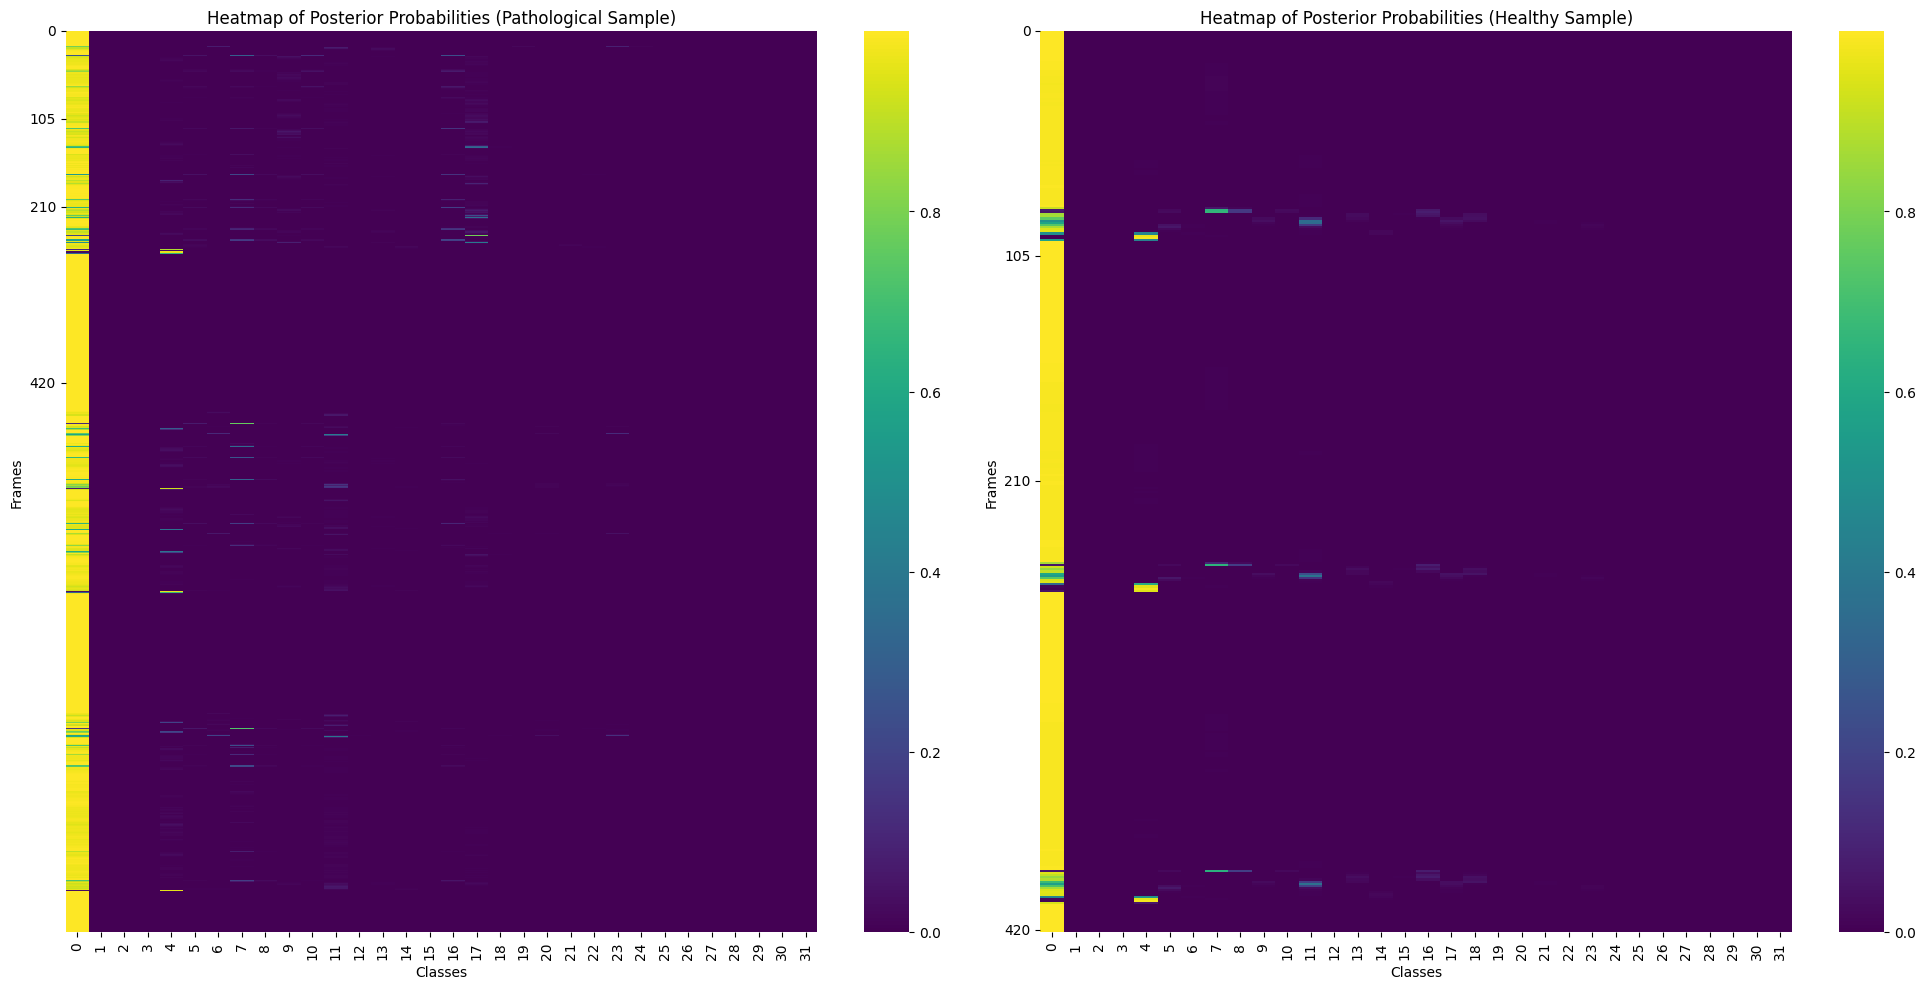

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the number of frames
total_frames = posterior_probs_H.shape[0]  # Assuming both have the same number of frames

# Generate specific y-tick positions and labels
y_ticks_positions = [0, total_frames // 4, total_frames // 2, total_frames - 1]
y_ticks_labels = ['0', f'{total_frames // 4}', f'{total_frames // 2}', f'{total_frames - 1}']

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot the heatmap for the healthy sample
sns.heatmap(posterior_probs_P, cmap="viridis", cbar=True, ax=axes[0])
axes[0].set_title('Heatmap of Posterior Probabilities (Pathological Sample)')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Frames')
axes[0].set_yticks(y_ticks_positions)
axes[0].set_yticklabels(y_ticks_labels)

# Plot the heatmap for the pathologic sample
sns.heatmap(posterior_probs_H, cmap="viridis", cbar=True, ax=axes[1])
axes[1].set_title('Heatmap of Posterior Probabilities (Healthy Sample)')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Frames')
axes[1].set_yticks(y_ticks_positions)
axes[1].set_yticklabels(y_ticks_labels)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


